In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import numpy as np
import random

In [241]:
class comparison:
    def __init__(self, iterations, limit_1, limit_2):
        self.__iterations = iterations
        self.__limits = (limit_1, limit_2)
        self.__results = self.get_results(iterations, limit_1, limit_2)
        
    def get_limits(self):
        return self.__limits
    
    def get_iterations(self):
        return self.__iterations
    
    def get_df(self):
        return self.__results
    
    def get_score(self, hand_ls):
        '''
        gets the best score depending on the given hand
        
        hand_ls[0] -> the array of cards which are not A's or B's
        hand_ls[1] -> the number of A's (Can be 0,1)
        hand_ls[2] -> the number of B's (Can be 0,1)
        '''
        
        # possibilities of outcomes for different combination of A's
        A_possibilities = dict()
        A_possibilities[(0,0)] = [0]
        A_possibilities[(0,1)] = [-11,-1]
        A_possibilities[(1,0)] = [1,10]
        A_possibilities[(1,1)] = [-10,0,10]
        
        # hand_sum is the sum of the hand without considering A's and B's
        hand_sum = sum(hand_ls[0])
        
        # add all possibilities for A's and B's
        current_possibilities = list(map(lambda x: x + hand_sum, A_possibilities[(hand_ls[1], hand_ls[2])]))
        
        # take largest possibility < 26
        for current_possibility in reversed(current_possibilities):
            if current_possibility < 26:
                return current_possibility
        
        # if all possibilities > 26, the hand has "exploded"
        return -1000
    
    def get_draw(self, limit):
        '''draw cards depending on the limit strategy'''
        
        all_cards = np.arange(1,10).tolist() + np.arange(-9,0).tolist()
        all_cards = all_cards + [10]*3 + [-10]*3 + ["A"] + ["B"]
        
        cards_left = all_cards
        current_hand = [list(), 0, 0]
        
        for number_of_cards_left in range (26,0,-1):
            # get random card
            current_index = random.randint(0, number_of_cards_left - 1)
            current_card = cards_left[current_index]
            
            # remove card from cards_left and add to current_hand
            if current_card == "A":
                current_hand[1] += 1
            elif current_card == "B":
                current_hand[2] += 1
            else:
                current_hand[0].append(current_card)
            
            cards_left = cards_left[:current_index] + cards_left[current_index+1:]
            
            # calculate score of hand
            current_score = self.get_score(current_hand)
            
            if current_score >= limit:
                return current_score
            elif current_score == -1000:
                # if hand has "exploded", score = 0
                return 0
        
        return current_score
        
    
    def get_results(self, iterations, limit_1, limit_2):
        score_1 = list()
        score_2 = list()
        results = list()
        
        with progressbar.ProgressBar(max_value = iterations) as bar:
            for x in range (0,iterations):
                bar.update(x)
                current_score_1 = self.get_draw(limit_1)
                current_score_2 = self.get_draw(limit_2)
                
                score_1.append(current_score_1)
                score_2.append(current_score_2)
                
                if current_score_1 > current_score_2:
                    results.append(1)
                elif current_score_1 < current_score_2:
                    results.append(2)    
                else:
                    results.append(3)    
        
        results_dict = dict()
        results_dict["Score 1"] = score_1
        results_dict["Score 2"] = score_2
        results_dict["Results"] = results
        
        return pd.DataFrame(results_dict)

In [242]:
comparing_16_17 = comparison(100000,16,17)

100% (100000 of 100000) |################| Elapsed Time: 0:00:13 Time:  0:00:13


In [243]:
df = comparing_16_17.get_df()

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 22911.,     0.,     0.,     0.,     0.,     0.,
        14562., 13154., 11296.,  9741.,  9622.,  5692.,  4644.,  3666.,
         2792.,  1920.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Patch objects>)

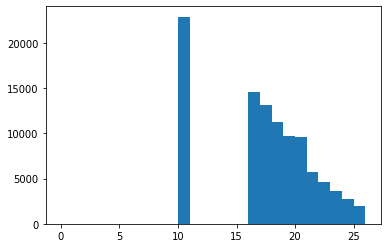

In [244]:
plt.hist(df["Score 1"], bins = np.arange(0,27))

(array([  509.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 26066.,     0.,     0.,     0.,     0.,     0.,
            0., 15314., 12685., 11014., 10885.,  6911.,  5594.,  4537.,
         3527.,  2958.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 26 Patch objects>)

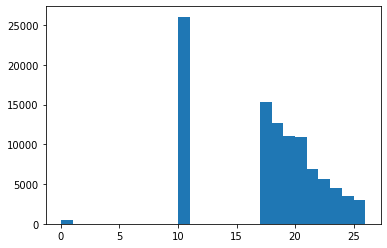

In [245]:
plt.hist(df["Score 2"], bins = np.arange(0,27))

(array([39751., 47556., 12693.]),
 array([1, 2, 3, 4]),
 <a list of 3 Patch objects>)

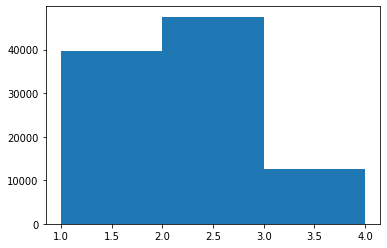

In [246]:
plt.hist(df["Results"], bins = np.arange(1,5))